# Import 

In [1]:
import os
import sys
import torch
import pytorch3d

/home/anirban/anaconda2/envs/pytorch3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
sys.path.append(os.path.abspath(''))

### 1. Load a mesh and texture file


In [3]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [5]:

import pickle
from pytorch3d.renderer import Textures
from scipy.spatial.transform import Rotation as SciR
from pytorch3d.renderer.cameras import PerspectiveCameras
from pytorch3d.renderer.lighting import AmbientLights
import numpy as np

In [21]:
def get_inputs(verts_T_paths,
                euler_list = None,
                tm_paths = None,
                change_handedness = True,
                degrees = True,
                require_grad = True,
                dtype = torch.float32):


    """ 
    retuns a dict of inputs; used in render function
    inputs :
    verts_T_paths : path to the verts_T file ; pickle file from smplmarket dataset
    euler_list : euler angles for the camera (in degrees)
    degree : if True, euler angles are in degrees
    texture_map_path : path to the texture map
    change_handedness : if True, flips the y axis of the verts and T

    returns : dict of inputs for the renderer
                all are torch tensors

            verts   : verts of the mesh (batch_size,6890,3)
            T       : translation vector (batch_size,3)
            R       : rotation matrix (batch_size,3,3)
            texture_map : texture map (batch_size,H,W,3)

    """

    # get the batch size and assert 
    batch_size = len(verts_T_paths)
    assert tm_paths is None or len(tm_paths) == batch_size, "number of texture map paths should be equal to batch size"
    assert euler_list is None or len(euler_list) == batch_size, "number of euler angles should be equal to batch size"
    
    #verts,T
    verts, T,_,_ = zip(*[pickle.load(open(path, 'rb')) for path in verts_T_paths])
    verts, T = np.array(verts), np.array(T) # to speed up 
    verts, T = torch.tensor(verts, dtype=dtype), torch.tensor(T, dtype=dtype)
    
    if change_handedness:
        verts[:,:,1] *= -1
        T[:,1] *= -1
    
    # R
    R = [SciR.from_euler('zyx', euler, degrees=degrees).as_matrix() for euler in (euler_list or np.zeros((batch_size,3)))]
    R = torch.from_numpy(np.array(R)).type(dtype)
    
    # texture map
    texture_map = torch.stack([torch.Tensor(np.array(plt.imread(path))) for path in (tm_paths or [])], 0).type(dtype) if tm_paths else None
        
    # set requires grad to true
    if require_grad:
        verts.requires_grad = T.requires_grad = R.requires_grad = True
        if texture_map is not None:
            texture_map.requires_grad = True
    
    inputs = { 'verts':verts,
                'T':T,
                'R':R,
                'texture_map':texture_map,
                'batch_size':batch_size,
                }
    return inputs

In [22]:
def render(inputs_dict,
                standard_body_path,
                image_resolution = 224,
                focal_length = 5000,
                faces_per_pixel = 1,                              
                device='cuda:0'):
    """
    renders the mesh with the given inputs
    inputs:
    inputs_dict : dict of inputs; output of get_inputs()
    standard_body_path : path to the standard body pickle file
                        { it must contain the following keys:
                            'vert_uv' : torch tensor of shape (1,7576,2)
                            'face_uvs' : torch tensor of shape (1,13776,3)
                            'faces' : torch tensor of shape (1,13776,3)
                        }

    returns : batch of image of shape (batch_size,image_resolution,image_resolution,4)
    """

    # --------------------------- loading data  ------------------------------------

    # load the data
    with open(standard_body_path, 'rb') as f:
        standard_values = pickle.load(f)
    
    
    # get the inputs
    verts = inputs_dict['verts']
    T = inputs_dict['T']
    R = inputs_dict['R']
    texture_map = inputs_dict['texture_map']
    batch_size = inputs_dict['batch_size']

    verts_uvs = standard_values['vert_uv'].repeat(batch_size,1,1)
    faces_uvs = standard_values['face_uvs'].repeat(batch_size,1,1)
    faces = standard_values['faces'].repeat(batch_size,1,1)

    # --------------------------- settings  ---------------------------------

    # create texture and mesh
    # Textures class is deprecated. change it later
    tex = Textures(verts_uvs=verts_uvs,
                   faces_uvs=faces_uvs,
                   maps=texture_map)
    
    mesh = Meshes(verts=verts, faces = faces,textures=tex)


    image_size = ((image_resolution, image_resolution),)
    fcl_screen = (focal_length, )                           # change it later to include resolution
    prp_screen = ((image_resolution/2, image_resolution/2),)

    cameras = PerspectiveCameras(focal_length = fcl_screen,
                                principal_point = prp_screen,
                                in_ndc = False,
                                image_size = image_size,
                                R = R,
                                T = T,
                                device = device)
   
    raster_settings = RasterizationSettings(
        image_size=image_resolution,
        blur_radius=0.0,
        faces_per_pixel=faces_per_pixel,
    )

    lights = AmbientLights(device=device)

    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )

    # move to device
    mesh = mesh.to(device)
    renderer = renderer.to(device)

    # --------------------------- render ------------------------------------

    images = renderer(mesh) 
    images[...,:3]/= 255.0  # normalize rgb values but not alpha channel.
    # image = images[0, ..., :]
    # get alpha_max 
    # alpha_max = np.max(image[...,3])
    # image[...,3] = np.where(image[...,3] > alpha_max/2, 1.0, 0.0)
    image = torch.flip(images, [2])
    return image 


# running these

In [24]:

verts_T_paths = ['/home/anirban/ashok_b/smpl_market_download/SMPLMarket/SMPL_RSC/pkl/1125_c1s5_020361_01.pkl',
                 '/home/anirban/ashok_b/projct_pytorch3d/hmr_models/data_point/0000_c1s1_000151_01.pkl',
                 '/home/anirban/ashok_b/smpl_market_download/SMPLMarket/SMPL_RSC/pkl/0002_c2s1_123041_01.pkl',
                 '/home/anirban/ashok_b/smpl_market_download/SMPLMarket/SMPL_RSC/pkl/0002_c1s2_000841_01.pkl',
                 '/home/anirban/ashok_b/smpl_market_download/SMPLMarket/SMPL_RSC/pkl/0002_c1s1_000801_01.pkl']
texture_path =  '/home/anirban/ashok_b/projct_pytorch3d/hmr_models/default_texture.jpg'

standard_body_path = '/home/anirban/ashok_b/projct_pytorch3d/standard_body.pkl'

tm_path = [texture_path]*5

inputs = get_inputs(verts_T_paths, tm_paths = tm_path)
images = render(inputs, standard_body_path )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


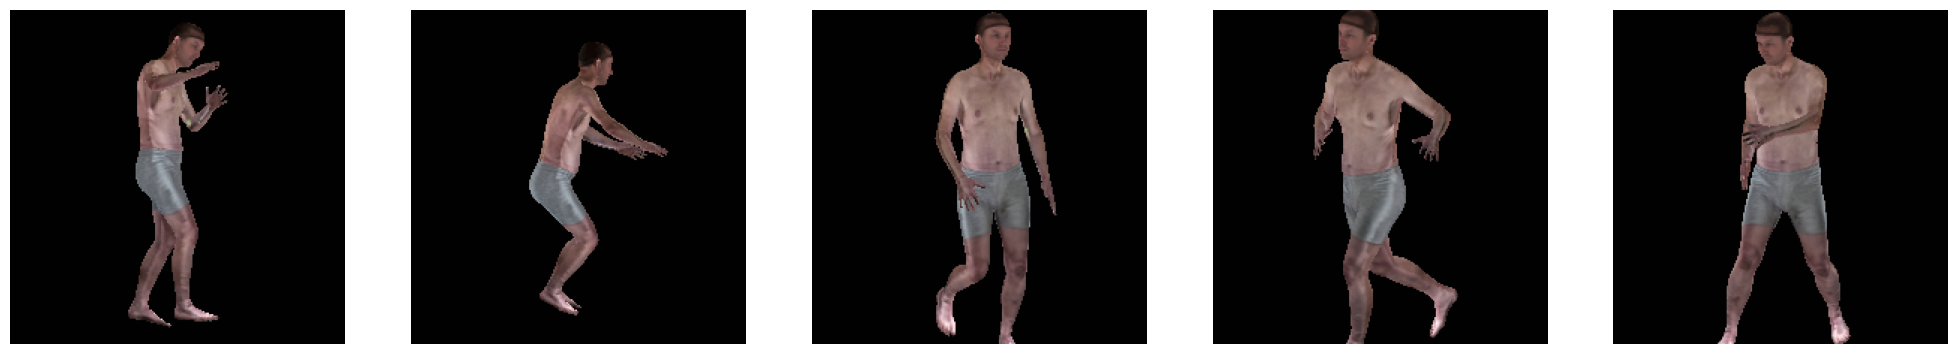

In [26]:
# images = renderer(mesh) 

n = len(images)
fig = plt.figure(figsize=(n*5, 5))
for i, image in enumerate(images):
    ax = fig.add_subplot(1, n, i + 1)
    temp = image.detach().cpu().numpy()[..., :3] 
    ax.imshow(temp)
    ax.axis("off")
plt.show()

# image and render

In [18]:
# from hmr utils 
"""
Preprocessing stuff.
"""
import numpy as np
import cv2


def resize_img(img, scale_factor):
    new_size = (np.floor(np.array(img.shape[0:2]) * scale_factor)).astype(int)
    new_img = cv2.resize(img, (new_size[1], new_size[0]))
    # This is scale factor of [height, width] i.e. [y, x]
    actual_factor = [
        new_size[0] / float(img.shape[0]), new_size[1] / float(img.shape[1])
    ]
    return new_img, actual_factor


def scale_and_crop(image, scale, center, img_size):
    image_scaled, scale_factors = resize_img(image, scale)
    # Swap so it's [x, y]
    scale_factors = [scale_factors[1], scale_factors[0]]
    center_scaled = np.round(center * scale_factors).astype(int)

    margin = int(img_size / 2)
    image_pad = np.pad(
        image_scaled, ((margin, ), (margin, ), (0, )), mode='edge')
    center_pad = center_scaled + margin
    # figure out starting point
    start_pt = center_pad - margin
    end_pt = center_pad + margin
    # crop:
    crop = image_pad[start_pt[1]:end_pt[1], start_pt[0]:end_pt[0], :]
    proc_param = {
        'scale': scale,
        'start_pt': start_pt,
        'end_pt': end_pt,
        'img_size': img_size
    }

    return crop, proc_param

In [ ]:
# image_path = "hmr_models/data_point/image_0000_c1s1_000151_01.jpg"

# image_path = "hmr_models/data_point/image_1125_c1s5_020361_01.jpg"


# 1125_c1s5_020361_01
import cv2
img = cv2.imread(image_path)
# img = image
if np.max(img.shape[:2]) != 224:
    print('Resizing so the max image size is 224' )
    scale = (float(224) / np.max(img.shape[:2]))
else:
    scale = 1.
center = np.round(np.array(img.shape[:2]) / 2).astype(int)
# image center in (x,y)
center = center[::-1]


crop, proc_param = scale_and_crop(img, scale, center,
                                             224)

# Normalize image to [-1, 1]
# crop = 2 * ((crop / 255.) - 0.5)

# plt.imshow(crop)


# ============== plotting =================


# overlay the two images
# normal_image = images[0, ...,:3].cpu().numpy()
# flipped_image = np.flip(normal_image, axis=1)

plt.figure(figsize=(3,3))
plt.imshow(crop[:, :, ::-1])
# uncropped = cv2.imread(image_path)
# plt.imshow(uncropped)
plt.imshow(rendered_image)

plt.axis("off")

# # plot side by side
# plt.figure(figsize=(5,5))
# plt.subplot(1, 2, 1)
# plt.imshow(crop[:, :, ::-1])
# plt.title("Original")
# plt.axis("off")
# plt.subplot(1, 2, 2)
# plt.imshow(rendered_image)
# plt.title("Textured")
# plt.axis("off")
